In [179]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from iexfinance.refdata import get_symbols
import matplotlib.pyplot as plt
%matplotlib inline

In [180]:
np.random.seed(42)

# Portfolio Planner

In this activity, you will use the iexfinance api to grab historical data for a 60/40 portfolio using `SPY` to represent the stock portion and `AGG` to represent the bonds.

In [181]:
from iexfinance.stocks import get_historical_data
import iexfinance as iex


# Data Collection

In this step, you will need to use the IEX api to fetch closing prices for the `SPY` and `AGG` tickers. Save the results as a pandas DataFrame

In [182]:
df = pd.read_hdf('SPYandAGG_Data.h5')
df

,SPY,AGG
,close,close
date,,
2019-02-04,271.96,106.88
2019-02-05,273.10,107.11
2019-02-06,272.74,107.05
2019-02-07,270.14,107.10
2019-02-08,270.47,107.34
...,...,...
2020-01-28,326.89,114.04
2020-01-29,326.62,114.30


# Monte Carlo Simulation

In this step, you will run Monte Carlo Simulations for your portfolio to model portfolio performance at different retirement ages. 

Complete the following steps:
1. Calculate the daily returns for the SPY and AGG closing prices.
2. Calculate volatility for both the SPY and AGG closing prices.
3. Find the last day's closing price for both stocks and save those as variables.
4. Run a Monte Carlo Simulation of at least 500 iterations and generate at least 30 years of closing prices

### HINTS:
There are 252 trading days per year, so the number of records to generate for each Monte Carlo run will be 252 days * 30 years

In [183]:
# Calculate the daily retunrs for the stocks
df.drop(columns=['open', 'high', 'low', 'volume'], level=1)
daily_returns = df.pct_change()
daily_returns

,SPY,AGG
,close,close
date,,
2019-02-04,NaN,NaN
2019-02-05,0.004192,0.002152
2019-02-06,-0.001318,-0.000560
2019-02-07,-0.009533,0.000467
2019-02-08,0.001222,0.002241
...,...,...
2020-01-28,0.010479,-0.000876
2020-01-29,-0.000826,0.002280


In [184]:
daily_returns.dropna(inplace=True)
daily_returns.head()
avg_daily_returns = daily_returns.mean()
avg_daily_returns

SPY  close    0.000698
AGG  close    0.000282
dtype: float64

In [185]:
# Calculate volatility
spy_volatility = daily_returns.std()['SPY']['close']
agg_volatility = daily_returns.std()['AGG']['close']
spy_volatility

0.007490927256700775

In [186]:
# Setup the Monte Carlo Parameters
number_simulations = 500
number_records = 252 * 30

# Set last closing prices of `JNJ` and `MU`
spy_last_price = df['SPY']['close'][-1]
agg_last_price = df['AGG']['close'][-1]

# Initialize empty DataFrame to hold simulated prices for each simulation
simulated_price_df = pd.DataFrame()
portfolio_cumulative_returns = pd.DataFrame()

#
spy_random_list = np.random.normal(avg_daily_returns['SPY']['close'], 
                                        spy_volatility,252*30*500).reshape(252*30,500)
agg_random_list = np.random.normal(avg_daily_returns['AGG']['close'], 
                                        agg_volatility,252*30*500).reshape(252*30,500)


In [187]:
# Run the Monte Carlo Simulation
for x in range(number_simulations):
    
    # Initialize the simulated prices list with the last closing price of `SPY` and `AGG`
    simulated_spy_prices = [spy_last_price]
    simulated_agg_prices = [agg_last_price]
    
    # Simulate the returns for 30 years
    for i in range(number_records):
        
        # Calculate the simulated price using the last price within the list
        simulated_spy_prices_new = (simulated_spy_prices[-1] * (1 + spy_random_list[i][x]))
        simulated_agg_prices_new = (simulated_agg_prices[-1] * (1 + agg_random_list[i][x]))
        
        # Append the simulated price to the list
        simulated_spy_prices.append(simulated_spy_prices_new)
        simulated_agg_prices.append(simulated_agg_prices_new)
    
    # Append a simulated prices of each simulation to DataFrame
    simulated_price_df["SPY prices"] = pd.Series(simulated_spy_prices)
    simulated_price_df["AGG prices"] = pd.Series(simulated_agg_prices)
    
    # Calculate the daily returns of simulated prices
    simulated_daily_returns = simulated_price_df.pct_change()
    
    # Set the portfolio weights (60% SPY; 40% AGG)
    weights = [0.6, 0.4]
    
    # Use the `dot` function with the weights to multiply weights with each column's 
    # simulated daily returns
    portfolio_daily_returns = simulated_daily_returns.dot(weights)
    
    # Calculate the normalized, cumulative return series
    portfolio_cumulative_returns[x] = (1 + portfolio_daily_returns.fillna(0)).cumprod()
       
portfolio_cumulative_returns.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.002327,0.999165,1.004356,1.007440,0.999681,0.997556,1.009057,1.003404,0.998275,1.002826,...,1.000033,1.006017,1.002645,0.998310,1.007376,1.003649,0.993847,1.000729,0.996905,0.993606
2,1.006592,1.009084,0.999163,1.009117,0.999628,0.995568,1.007341,1.000471,0.998506,0.999012,...,1.002610,0.996316,1.003014,0.996522,1.003363,1.001454,1.002602,1.003076,0.996548,0.995637
3,1.013131,1.012311,0.999870,1.006483,1.003355,0.995842,1.013309,1.003165,1.004041,0.995968,...,0.999811,1.007798,1.002473,0.998677,1.011873,1.012219,1.011768,1.008650,1.001155,0.999897
4,1.016536,1.010916,0.996274,1.006814,1.002525,0.994470,1.017495,1.007846,1.004880,1.003617,...,1.004831,1.012001,1.007397,1.002924,1.013733,1.017595,1.012818,1.004092,1.000692,0.996763


'500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 252 Trading Days'

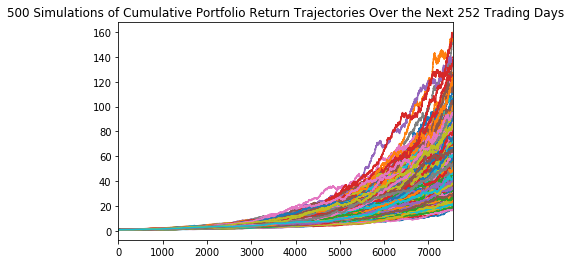

In [188]:
# Visualize the Simulation
plot_title = f"{x+1} Simulations of Cumulative Portfolio Return Trajectories Over the Next 252 Trading Days"
portfolio_cumulative_returns.plot(legend=None, title=plot_title)
plot_title

In [189]:
# Select the last row for the cumulative returns (cumulative returns at 30 years)
ending_cumulative_returns = portfolio_cumulative_returns.iloc[-(1), :]
ending_cumulative_returns.head()

0    57.871231
1    49.149850
2    47.063349
3    58.795038
4    52.838563
Name: 7560, dtype: float64

In [190]:
# Select the last row for the cumulative returns (cumulative returns at 20 years)
ending_cumulative_returns = portfolio_cumulative_returns.iloc[-(252*10), :]
ending_cumulative_returns.head()

0    16.409740
1    12.849472
2     8.228331
3    11.135378
4    17.044065
Name: 5041, dtype: float64

In [191]:
# Display the 90% confidence interval for the ending returns
confidence_interval = ending_cumulative_returns.quantile(q=[0.1, 0.9])
confidence_interval

0.1     8.833058
0.9    21.369287
Name: 5041, dtype: float64

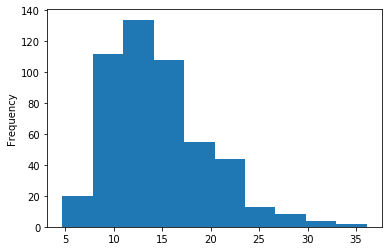

In [192]:
# Visualize the distribution of the ending returns
ending_cumulative_returns.plot(kind='hist', bins=10)

---

# Retirement Analysis

In this section, you will use the monte carlo model to answer the following retirement planning questions:

1. What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?
2. Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?
3. Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?
4. How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

### What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?

In [193]:
confidence_interval_p10 = ending_cumulative_returns.quantile(q=[0.9, 0.1])
confidence_interval_p10
confidence_interval_p50 = ending_cumulative_returns.quantile(q=[0.5, 0.5])
confidence_interval_p50
confidence_interval_p90 = ending_cumulative_returns.quantile(q=[0.1, 0.9])
print(confidence_interval_p10)
print(confidence_interval_p50)
print(confidence_interval_p90)

0.9    21.369287
0.1     8.833058
Name: 5041, dtype: float64
0.5    13.586704
0.5    13.586704
Name: 5041, dtype: float64
0.1     8.833058
0.9    21.369287
Name: 5041, dtype: float64


### Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?

In [194]:
initial_investment = 20000

expected_portfolio_returns_p10 = initial_investment + (initial_investment * confidence_interval_p10.iloc[0])

expected_portfolio_returns_p50 = initial_investment + (initial_investment * confidence_interval_p50.iloc[0])

expected_portfolio_returns_p90 = initial_investment + (initial_investment * confidence_interval_p90.iloc[0])

print(expected_portfolio_returns_p10)
print(expected_portfolio_returns_p50)
print(expected_portfolio_returns_p90)



447385.7372218901
291734.0844468683
196661.1594702293


### Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?

Note: This is effectively saying that 90% of the expected returns will be greater than the return at the 10th percentile, so this can help measure the uncertainty about having enough funds at retirement

In [195]:
Projected_income = 7389

withdrawl = expected_portfolio_returns_p10 * .04

print(f'Projected income is: {Projected_income}, which is less than a 4% withdrawl rate which yields: {withdrawl}')

Projected income is: 7389, which is less than a 4% withdrawl rate which yields: 17895.429488875605


### How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

In [196]:
initial_investment_increase = 20000 * 1.5
expected_portfolio_returns_p10_new = initial_investment_increase + (initial_investment_increase * confidence_interval_p10.iloc[0])


withdrawl_new = expected_portfolio_returns_p10_new * .04
withdrawl_new

print(f'Projected income is: {Projected_income}, which is less than a 4% withdrawl rate which yields: {withdrawl_new}')

Projected income is: 7389, which is less than a 4% withdrawl rate which yields: 26843.144233313407


### Optional Challenge

In this section, you will calculate and plot the cumulative returns for the median and 90% confidence intervals. This plot shows the expected cumulative returns for any given day between the first day and the last day of investment. 

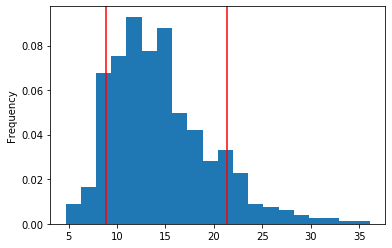

In [198]:
plt.figure();
ending_cumulative_returns.plot(kind='hist', density=True, bins=20)
plt.axvline(confidence_interval_p90.iloc[0], color='r')
plt.axvline(confidence_interval_p90.iloc[1], color='r')